### Binary Classification Model for Diabetes 130-US Hospitals Using Python and TensorFlow
### David Lowe
### June 21, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Diabetes 130-US Hospital dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: The data set is the Diabetes 130-US Hospitals for years 1999-2008 donated to the University of California, Irvine (UCI) Machine Learning Repository. The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes.

ANALYSIS: The performance of the cross-validated TensorFlow models achieved an average accuracy benchmark of 62.95% after running for 10 epochs. When we applied the final model to the test dataset, the model achieved an accuracy score of 63.60%.

CONCLUSION: In this iteration, the TensorFlow model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Diabetes 130-US Hospitals for years 1999-2008 Dataset

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://archive-beta.ics.uci.edu/ml/datasets/296

One potential source of performance benchmarks: http://www.hindawi.com/journals/bmri/2014/781670/

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jun 16 22:32:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 10
BATCH_SIZE = 32

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.5.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [10]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
dataset_path = 'https://dainesanalytics.com/datasets/ucirvine-diabetes-130-us-hospitals/diabetic_data.csv'
df_dataset_import = pd.read_csv(dataset_path, na_values='?')

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   encounter_id  patient_nbr             race  ... change diabetesMed readmitted
0       2278392      8222157        Caucasian  ...     No          No         NO
1        149190     55629189        Caucasian  ...     Ch         Yes        >30
2         64410     86047875  AfricanAmerican  ...     No         Yes         NO
3        500364     82442376        Caucasian  ...     Ch         Yes         NO
4         16680     42519267        Caucasian  ...     Ch         Yes         NO

[5 rows x 50 columns]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [13]:
print(df_dataset_import.describe())

       encounter_id   patient_nbr  ...  number_inpatient  number_diagnoses
count  1.017660e+05  1.017660e+05  ...     101766.000000     101766.000000
mean   1.652016e+08  5.433040e+07  ...          0.635566          7.422607
std    1.026403e+08  3.869636e+07  ...          1.262863          1.933600
min    1.252200e+04  1.350000e+02  ...          0.000000          1.000000
25%    8.496119e+07  2.341322e+07  ...          0.000000          6.000000
50%    1.523890e+08  4.550514e+07  ...          0.000000          8.000000
75%    2.302709e+08  8.754595e+07  ...          1.000000          9.000000
max    4.438672e+08  1.895026e+08  ...         21.000000         16.000000

[8 rows x 13 columns]


In [14]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

### 1.d) Data Cleaning

In [15]:
# Dropping features that are unique identifiers
df_dataset_import.drop(columns=['encounter_id','patient_nbr'], inplace=True)

# Dropping features not relevant according to the study
df_dataset_import.drop(columns=['gender','weight','payer_code','diag_2','diag_3'], inplace=True)
df_dataset_import.drop(columns=['metformin','repaglinide','nateglinide','chlorpropamide',
                                'glimepiride','acetohexamide','glipizide','glyburide','tolbutamide',
                                'pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone',
                                'tolazamide','examide','citoglipton','insulin','glyburide-metformin',
                                'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone',
                                'metformin-pioglitazone'], inplace=True)

# Convert columns from one data type to another
df_dataset_import['admission_type_id'] = df_dataset_import['admission_type_id'].astype('category')
df_dataset_import['discharge_disposition_id'] = df_dataset_import['discharge_disposition_id'].astype('category')
df_dataset_import['admission_source_id'] = df_dataset_import['admission_source_id'].astype('category')

# Convert features with R/M levels into categorical feature of 0/1
def relabel_target(target):
    if target == 'NO': return 0
    else: return 1
df_dataset_import['target'] = df_dataset_import['readmitted'].apply(relabel_target)
df_dataset_import.drop(columns=['readmitted'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

              race      age admission_type_id  ... change diabetesMed  target
0        Caucasian   [0-10)                 6  ...     No          No       0
1        Caucasian  [10-20)                 1  ...     Ch         Yes       1
2  AfricanAmerican  [20-30)                 1  ...     No         Yes       0
3        Caucasian  [30-40)                 1  ...     Ch         Yes       0
4        Caucasian  [40-50)                 1  ...     Ch         Yes       0

[5 rows x 20 columns]


In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      99493 non-null   object  
 1   age                       101766 non-null  object  
 2   admission_type_id         101766 non-null  category
 3   discharge_disposition_id  101766 non-null  category
 4   admission_source_id       101766 non-null  category
 5   time_in_hospital          101766 non-null  int64   
 6   medical_specialty         51817 non-null   object  
 7   num_lab_procedures        101766 non-null  int64   
 8   num_procedures            101766 non-null  int64   
 9   num_medications           101766 non-null  int64   
 10  number_outpatient         101766 non-null  int64   
 11  number_emergency          101766 non-null  int64   
 12  number_inpatient          101766 non-null  int64   
 13  diag_1                    101

In [17]:
print(df_dataset_import.describe())

       time_in_hospital  num_lab_procedures  ...  number_diagnoses         target
count     101766.000000       101766.000000  ...     101766.000000  101766.000000
mean           4.395987           43.095641  ...          7.422607       0.460881
std            2.985108           19.674362  ...          1.933600       0.498470
min            1.000000            1.000000  ...          1.000000       0.000000
25%            2.000000           31.000000  ...          6.000000       0.000000
50%            4.000000           44.000000  ...          8.000000       0.000000
75%            6.000000           57.000000  ...          9.000000       1.000000
max           14.000000          132.000000  ...         16.000000       1.000000

[8 rows x 9 columns]


In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

race                         2273
age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
change                          0
diabetesMed                     0
target                          0
dtype: int64
Total number of NaN in the dataframe:  52243


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = total_column_count

In [20]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_import = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_import = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_import = df_dataset_import.iloc[:,1:total_column_count]
    df_target_import = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (101766, 20) df_features_import.shape: (101766, 19) df_target_import.shape: (101766,)


In [21]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, stratify=df_target_import, random_state=RNG_SEED)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (81412, 19) df_target_train.shape: (81412,)
df_features_test.shape: (20354, 19) df_target_test.shape: (20354,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

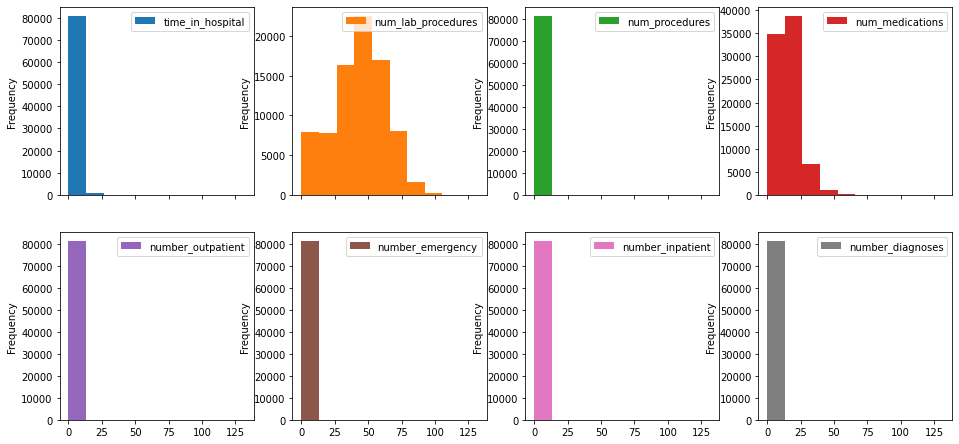

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

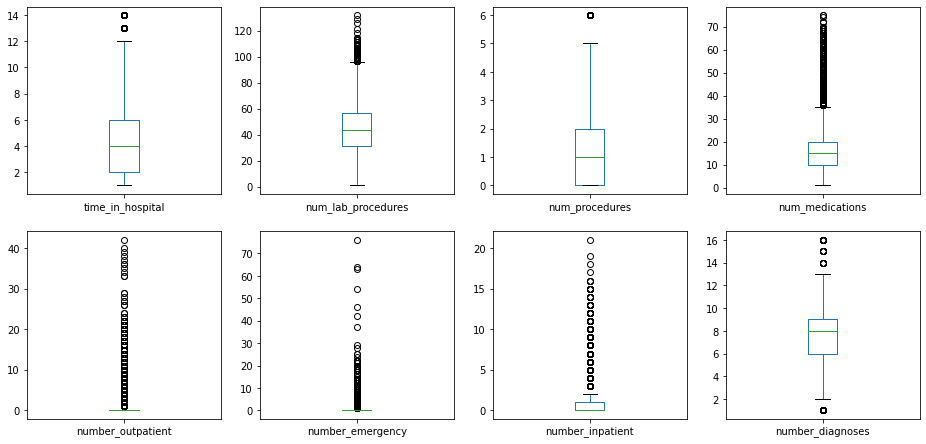

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

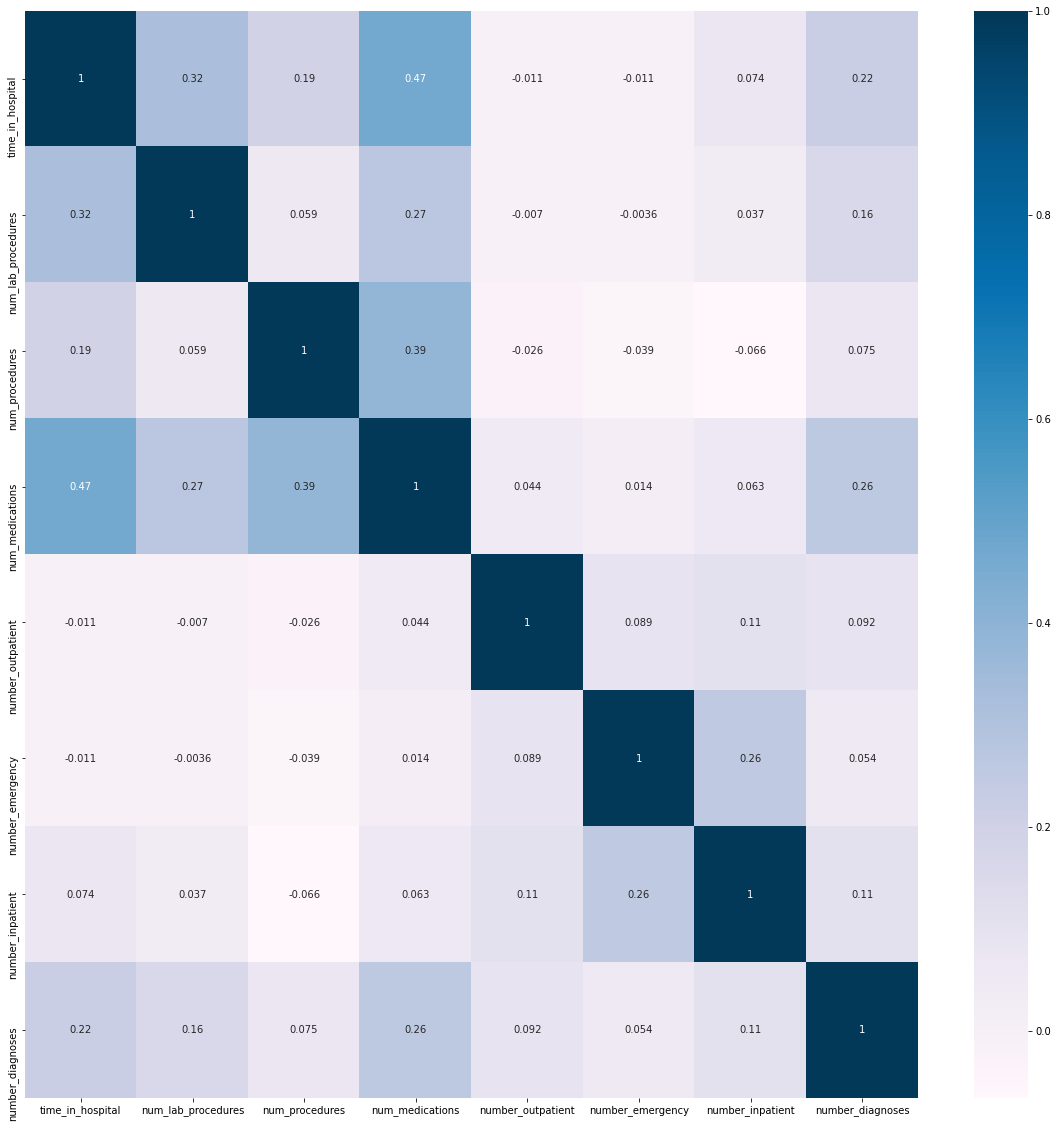

In [27]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [30]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 8
Number of categorical columns: 11
Total number of columns in the feature dataframe: 19


In [31]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (81412, 19) to array_features_train.shape: (81412, 860)


### 3.b) Training Data Balancing

In [32]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [34]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} df_target_train.shape: {}".format(array_features_train.shape, df_target_train.shape))

array_features_train.shape: (81412, 860) df_target_train.shape: (81412,)


In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [37]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=array_features_train.shape[1], layer1_nodes=512, layer2_nodes=384, layer3_nodes=256, layer4_nodes=128, layer5_nodes=64,
                    layer1_dropout=0.25, layer2_dropout=0.25, layer3_dropout=0.25, layer4_dropout=0.25, layer5_dropout=0.25,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(layer4_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer4_dropout),
        keras.layers.Dense(layer5_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer5_dropout),
        keras.layers.Dense(1, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [38]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_features_train):
    feature_train, feature_validation = array_features_train[train_ix], array_features_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    reset_random()
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=1)[1]
    iteration = iteration + 1
    print('Score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model scorer from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

509/509 [==============================] - 1s 2ms/step - loss: 0.6754 - accuracy: 0.6306
Score from iteration 1 >>> 0.6306
509/509 [==============================] - 1s 2ms/step - loss: 0.6857 - accuracy: 0.6328
Score from iteration 2 >>> 0.6328
509/509 [==============================] - 1s 2ms/step - loss: 0.6810 - accuracy: 0.6278
Score from iteration 3 >>> 0.6278
509/509 [==============================] - 1s 2ms/step - loss: 0.6947 - accuracy: 0.6281
Score from iteration 4 >>> 0.6281
509/509 [==============================] - 1s 2ms/step - loss: 0.6785 - accuracy: 0.6284
Score from iteration 5 >>> 0.6284
Average model scorer from all iterations: 0.6295 (0.0019)
Total time for model fitting and cross validating: 0:04:31.191799


In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [41]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
final_model = create_nn_model()
final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[learning_rate_reduction], verbose=1)
final_model.summary()

Epoch 1/10
2545/2545 [==============================] - 9s 3ms/step - loss: 0.6365 - accuracy: 0.6342
Epoch 2/10
2545/2545 [==============================] - 8s 3ms/step - loss: 0.6212 - accuracy: 0.6501
Epoch 3/10
2545/2545 [==============================] - 8s 3ms/step - loss: 0.6136 - accuracy: 0.6558
Epoch 4/10
2545/2545 [==============================] - 8s 3ms/step - loss: 0.6059 - accuracy: 0.6651
Epoch 5/10
2545/2545 [==============================] - 8s 3ms/step - loss: 0.5962 - accuracy: 0.6711
Epoch 6/10
2545/2545 [==============================] - 8s 3ms/step - loss: 0.5860 - accuracy: 0.6818
Epoch 7/10
2545/2545 [==============================] - 8s 3ms/step - loss: 0.5734 - accuracy: 0.6914
Epoch 8/10
2545/2545 [==============================] - 8s 3ms/step - loss: 0.5605 - accuracy: 0.7020
Epoch 9/10
2545/2545 [==============================] - 8s 3ms/step - loss: 0.5484 - accuracy: 0.7088
Epoch 10/10
2545/2545 [==============================] - 8s 3ms/step - loss: 0.537

### 6.b) Load Test Dataset and Prepare the Submission File

In [42]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (20354, 19) to array_features_test.shape: (20354, 860)


In [43]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_test = df_target_test.ravel()
print("array_features_test.shape: {} df_target_test.shape: {}".format(array_features_test.shape, df_target_test.shape))

array_features_test.shape: (20354, 860) df_target_test.shape: (20354,)


In [44]:
# Make batched predictions
test_predictions = (final_model.predict(array_features_test) > 0.5).astype('int').ravel()
print(test_predictions)

[0 1 0 ... 0 0 1]


In [45]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.6360420556156038
ROC/AUC Score: 0.6315205876003871
[[7564 3409]
 [3999 5382]]
              precision    recall  f1-score   support

           0       0.65      0.69      0.67     10973
           1       0.61      0.57      0.59      9381

    accuracy                           0.64     20354
   macro avg       0.63      0.63      0.63     20354
weighted avg       0.63      0.64      0.63     20354



In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:06:03.405031
